# Assignment: Linear Models
## Foundations of Machine Learning
## Do Q1 and one other question

**Q1.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.
2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?
3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?
4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.
7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

In [1]:
# necessary imports #
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [17]:
## q1.1 ##

df = pd.read_csv('./data/Q1_clean.csv')
# df.head()

df.rename(columns = {'Neighbourhood ':'Neighbourhood'}, inplace=True) # syntax issue #
df.loc[:,['Price','Neighbourhood']].groupby('Neighbourhood').describe()

# Manhattan is the most expensive bourough on avg in New York; its mean price is $183.66/night

Price                                                      \
                 count        mean         std   min     25%    50%    75%   
Neighbourhood                                                                
Bronx            217.0   75.276498   39.755468  10.0   50.00   60.0   90.0   
Brooklyn        8487.0  127.747378  106.038466  20.0   75.00  100.0  150.0   
Manhattan      11763.0  183.664286  170.434606  25.0  103.00  150.0  214.0   
Queens          1590.0   96.857233   61.712648  25.0   60.00   80.0  115.0   
Staten Island     96.0  146.166667  508.462029  35.0   54.75   71.0   99.0   

                        
                   max  
Neighbourhood           
Bronx            244.0  
Brooklyn        4500.0  
Manhattan      10000.0  
Queens           950.0  
Staten Island   5000.0

<Axes: xlabel='Price', ylabel='Density'>

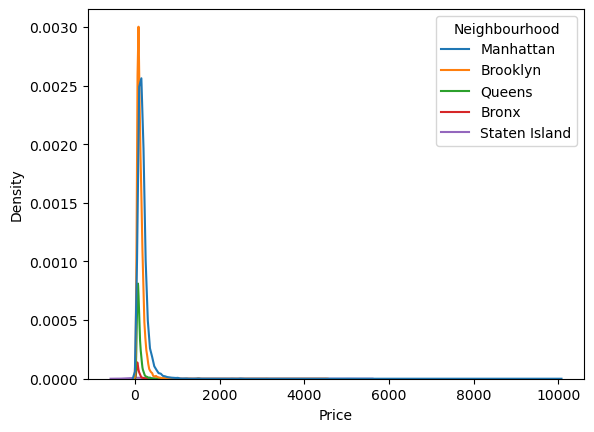

In [22]:
# kde plots #

sns.kdeplot(data = df, x = 'Price', hue = 'Neighbourhood')

<Axes: xlabel='Price', ylabel='Density'>

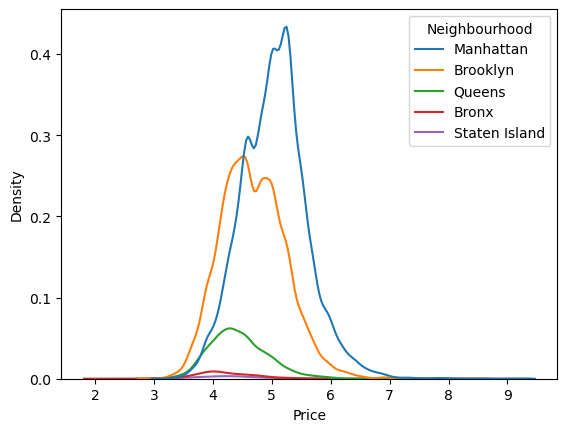

In [23]:
sns.kdeplot(data = df, x = np.log(df['Price']), hue = 'Neighbourhood')

In [27]:
## q1.2 ##

from sklearn import linear_model

X = pd.get_dummies(df['Neighbourhood'], dtype = 'int')
Y = df['Price']
regress = linear_model.LinearRegression(fit_intercept = False).fit(X, Y)

results = pd.DataFrame({'vars':regress.feature_names_in_, 'coeffs':regress.coef_})
results

# the variables in this regression model are the diff NY bouroughs and the coeffs are their respective avg mean prices like in q1.1
# the regression only uses the one Neighbourhood var, so it's only computing from that var
# the coeffs in the regression of a cont. var on one categorical variable (bouroughs in this case) is the group avgs of everything
# included in the regression

,vars,coeffs
0,Bronx,75.276498
1,Brooklyn,127.747378
2,Manhattan,183.664286
3,Queens,96.857233
4,Staten Island,146.166667


In [37]:
## q1.3 ##

X = pd.get_dummies(df['Neighbourhood'], dtype = 'int', drop_first = True)
Y = df['Price']
regress = linear_model.LinearRegression().fit(X, Y)

results = pd.DataFrame({'vars':regress.feature_names_in_, 'coeffs':regress.coef_})
print('intercept:', regress.intercept_)
results


# Bronx was dropped from vars column and consequently its value in the coeffs column was deducted from each 
# Also the regression intercept was the same value that Bronx had from the prior questions
# all the remaining coeffs now are in respect to the Bronx entry bc adding the regression back to the coeffs, just makes it
# as it was in q1.2, w/o the intercept

intercept: 75.27649769585337


,vars,coeffs
0,Brooklyn,52.470881
1,Manhattan,108.387789
2,Queens,21.580735
3,Staten Island,70.890169


In [40]:
# validation #

results = pd.DataFrame({'vars':regress.feature_names_in_, 'coeffs':regress.coef_ + regress.intercept_})
results

# same original values if Bronx were still included

,vars,coeffs
0,Brooklyn,127.747378
1,Manhattan,183.664286
2,Queens,96.857233
3,Staten Island,146.166667


In [45]:
## q1.4 ##

from sklearn.model_selection import train_test_split

X = df.loc[:,['Review Scores Rating', 'Neighbourhood']]
Y = df['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

Z_train = pd.concat([X_train['Review Scores Rating'], pd.get_dummies(X_train['Neighbourhood'], dtype = 'int')], axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'], pd.get_dummies(X_test['Neighbourhood'], dtype = 'int')], axis = 1)

regress = linear_model.LinearRegression(fit_intercept = False).fit(Z_train, Y_train)

Y_hat = regress.predict(Z_test)
print('R^2:', regress.score(Z_test, Y_test))
rmse = np.sqrt(np.mean((Y_test - Y_hat) ** 2))
print('RMSE:', rmse)

results = pd.DataFrame({'vars':regress.feature_names_in_, 'coeffs': regress.coef_})
results

# r^2 is 0.0670 which is not very strong
# rmse is 125.0109 which shows that the avg differences b/w the model's vals and true vals is 125 which is very high
# the coeff on the RSR is 1.0322; the most expensive property you can rent is an entire home/apartment in Manhattan

R^2: 0.06701086106947296
RMSE: 125.01092061382933


,vars,coeffs
0,Review Scores Rating,1.032257
1,Bronx,-17.261392
2,Brooklyn,32.180888
3,Manhattan,89.421020
4,Queens,4.050208
5,Staten Island,61.576393


In [47]:
## q1.5 ##

X = df.loc[:,['Review Scores Rating', 'Neighbourhood', 'Room Type']]
Y = df['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100)

Z_train = pd.concat([X_train['Review Scores Rating'], pd.get_dummies(X_train['Neighbourhood'], dtype = 'int'), pd.get_dummies(X_train['Room Type'], dtype = 'int')], axis = 1)
Z_test = pd.concat([X_test['Review Scores Rating'], pd.get_dummies(X_test['Neighbourhood'], dtype = 'int'), pd.get_dummies(X_test['Room Type'], dtype = 'int')], axis = 1)

regress = linear_model.LinearRegression(fit_intercept = False).fit(Z_train, Y_train)

Y_hat = regress.predict(Z_test)
print('R^2:', regress.score(Z_test, Y_test))
rmse = np.sqrt(np.mean((Y_test - Y_hat) ** 2))
print('RMSE:', rmse)

results = pd.DataFrame({'vars':regress.feature_names_in_, 'coeffs': regress.coef_})
results

# r^2 is 0.2204 which is not very strong, but stronger than the one in q1.4
# rmse is 114.2769 which shows that the avg differences b/w the model's vals and true vals is 114 which is pretty high
# the coeff on the RSR is 0.6269; the most expensive property you can rent is an entire home/apartment in Manhattan

R^2: 0.22035348129282317
RMSE: 114.27692123130633


,vars,coeffs
0,Review Scores Rating,0.626912
1,Bronx,-13.022765
2,Brooklyn,10.378456
3,Manhattan,53.693304
4,Queens,-6.833330
5,Staten Island,50.003022
6,Entire home/apt,110.617820
7,Private room,3.101341
8,Shared room,-19.500474


q1.6

it changed from 1.03 to 0.63 from q1.4 to q1.5; for mult. linear regression, first is regression of the desired x and y on the other vars, mark the residuals, then regress those residuals on each other – from 1.4 to 1.5 Room Type was added and what's shown is that some of the variation in prices by rating and neighbourhood is explained by the room types available in those bouroughs. if  room type is locked, the other vars become less powerful predictors since some of that power goes to room type, which is why the coeff decreased

**Q2.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

Index(['Unnamed: 0', 'Make', 'Make_Year', 'Color', 'Body_Type', 'Mileage_Run',
       'No_of_Owners', 'Seating_Capacity', 'Fuel_Type', 'Transmission',
       'Transmission_Type', 'Price'],
      dtype='object')


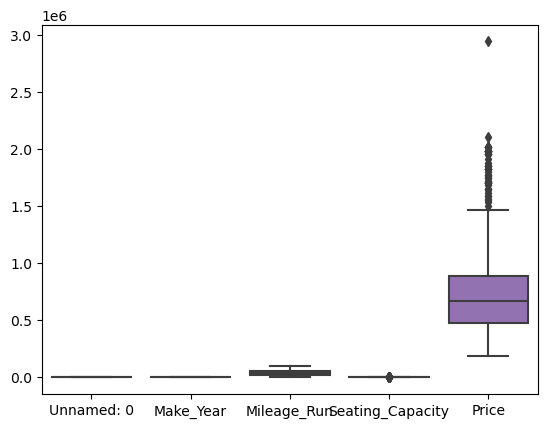

In [67]:
## q2.1 ##

df = pd.read_csv('./data/cars_hw.csv')
data = df
sns.boxplot(data = df)
print(df.columns)

<Axes: >

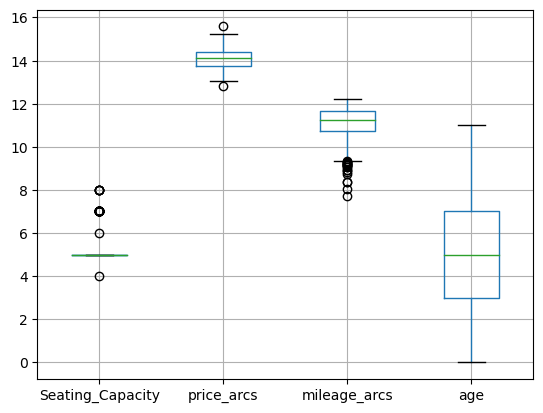

In [68]:
# cleaning boxplot 

df['price_arcs'] = np.arcsinh(df['Price'])
df['mileage_arcs'] = np.arcsinh(df['Mileage_Run'])
df['age'] = max(df['Make_Year']) - df['Make_Year']
df = df.drop(['Price', 'Mileage_Run', 'Make_Year', 'Unnamed: 0'], axis = 1)
df.boxplot()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,4.535000e+05,2.466064e+05,267000.0,288500.0,345500.0,537500.0,892000.0
Datsun,3.0,2.896667e+05,1.050397e+04,279000.0,284500.0,290000.0,295000.0,300000.0
Ford,52.0,7.211731e+05,1.409277e+05,290000.0,635000.0,707500.0,787000.0,1066000.0
Honda,73.0,7.989726e+05,2.665091e+05,316000.0,581000.0,785000.0,915000.0,1537000.0
Hyundai,305.0,6.918918e+05,2.791597e+05,248000.0,485000.0,638000.0,837000.0,1742000.0
Jeep,4.0,1.499500e+06,1.525134e+05,1290000.0,1447500.0,1529500.0,1581500.0,1649000.0
Kia,8.0,1.614750e+06,1.190567e+05,1369000.0,1579000.0,1628500.0,1705750.0,1741000.0
MG Motors,35.0,1.869457e+06,1.216611e+05,1589000.0,1786500.0,1848000.0,1978000.0,2019000.0
Mahindra,18.0,1.100167e+06,1.755493e+05,796000.0,1037000.0,1094500.0,1157000.0,1465000.0


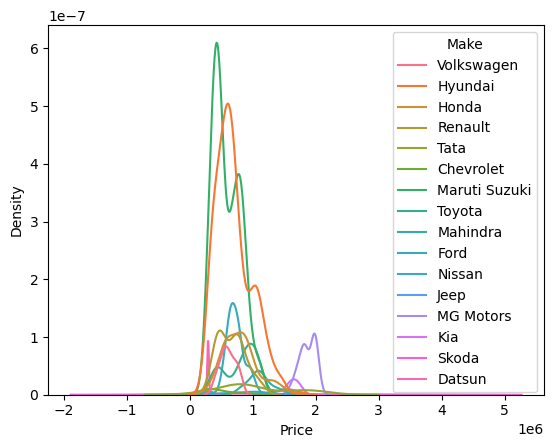

In [69]:
## q2.2 ##

sns.kdeplot(data = data, x = 'Price', hue = 'Make')
data['Price'].groupby(data['Make']).describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,13.613042,0.480975,13.188151,13.261539,13.445433,13.864828,14.394369
Datsun,3.0,13.269194,0.036311,13.232114,13.251449,13.270783,13.287734,13.304685
Ford,52.0,14.161427,0.210895,13.270783,14.054527,14.162640,14.269131,14.572571
Honda,73.0,14.229465,0.336972,13.356645,13.965653,14.266586,14.419827,14.938490
Hyundai,305.0,14.061658,0.398781,13.114331,13.785051,14.059241,14.330727,15.063692
Jeep,4.0,14.909738,0.105084,14.763300,14.876417,14.933413,14.966733,15.008827
Kia,8.0,14.985324,0.076877,14.822738,14.965389,14.996253,15.042662,15.063117
MG Motors,35.0,15.132199,0.066263,14.971763,15.088892,15.122762,15.190744,15.211260
Mahindra,18.0,14.592100,0.159906,14.280502,14.544955,14.598828,14.654396,14.890513


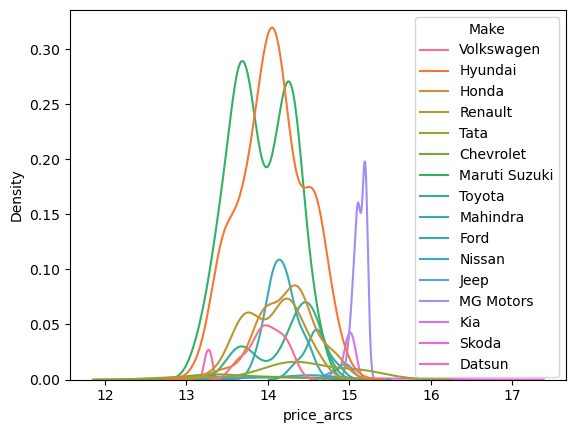

In [70]:
sns.kdeplot(data = data, x = 'price_arcs', hue = 'Make')
df['price_arcs'].groupby(df['Make']).describe()

MG Motors cars are the most expensive on avg, as indicated by the charts, followed by Kia and then Jeep. the kdeplot for cleaned data shows that car prices generally have one main peak, but for the Maruti Suzuki and Toyota especially, their graphs are more bimodal. the price range starts as low as $188k (Tata) and shoots up to $2.9 mil (Skoda), measured in Indian Rupees

<Axes: xlabel='Price', ylabel='Density'>

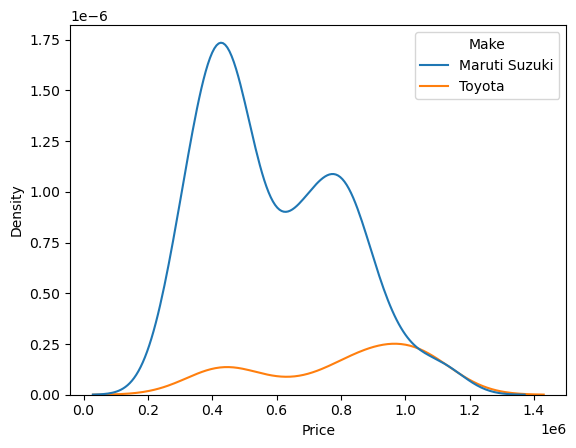

In [82]:
sns.kdeplot(data = data.loc[df['Make'].isin(['Maruti Suzuki', 'Toyota']),:], x = 'Price', hue = 'Make')

<Axes: xlabel='Price', ylabel='Density'>

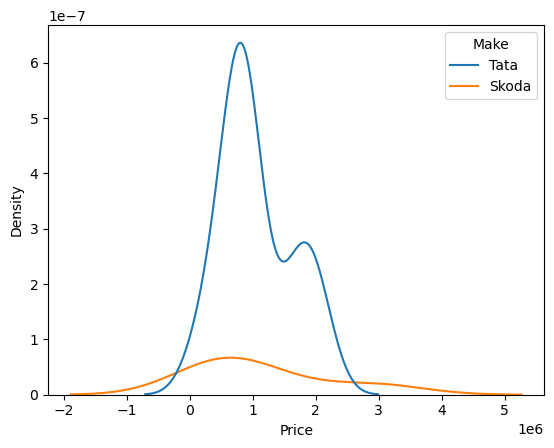

In [75]:
sns.kdeplot(data = data.loc[df['Make'].isin(['Skoda', 'Tata']),:], x = 'Price', hue = 'Make')

In [77]:
## q2.3 ##

N = df.shape[0]
df = df.sample(frac = 1, random_state = 100)
train_size = int(0.8 * N)

df_train = df[0:train_size]
Y_train = df_train['price_arcs']

df_test = df[train_size:]
Y_test = df_test['price_arcs']

In [78]:
## q2.4 ##

# numerical #
var_n = ['age', 'mileage_arcs', 'Seating_Capacity']
X_train_n = df_train.loc[:, var_n]
regress_n = linear_model.LinearRegression().fit(X_train_n, Y_train)
X_test_n = df_test.loc[:, var_n]
Y_hat = regress_n.predict(X_test_n)
print('numeric R^2:', regress_n.score(X_test_n, Y_test))
rmse_n = np.sqrt(np.mean((Y_test - Y_hat) ** 2))
print('numeric RMSE:', rmse_n)

numeric R^2: 0.47500291656763394
numeric RMSE: 0.31530652630313194


In [84]:
# categorical #

var_cat = ['Make', 'Body_Type', 'Color', 'Fuel_Type', 'Transmission', 'Transmission_Type']

dummies = pd.DataFrame([])
for var in var_cat: 
    new_dummies = pd.get_dummies(df.loc[:,var], drop_first = True, dtype = int)
    dummies = pd.concat([dummies, new_dummies], axis = 1, ignore_index = True) 
    X_train_c = dummies.iloc[0:train_size, :]
    X_test_c = dummies.iloc[train_size:, :]
regress_c = linear_model.LinearRegression().fit(X_train_c, Y_train)
Y_hat_c = regress_c.predict(X_test_c)
print('categorical R^2:', regress_c.score(X_test_c, Y_test))
rmse_c = np.sqrt(np.mean((Y_test - Y_hat_c) ** 2))
print('categorical RMSE:', rmse_c)

categorical R^2: 0.6328712991859703
categorical RMSE: 0.26367179960539366


In [83]:
# combined #

X_train_all = pd.concat([X_train_n, X_train_c], axis = 1, ignore_index = True)
X_test_all = pd.concat([X_test_n, X_test_c], axis = 1, ignore_index = True)

regress_all = linear_model.LinearRegression().fit(X_train_all, Y_train)
Y_hat_all = regress_all.predict(X_test_all)
print('R^2: ', regress_all.score(X_test_all, Y_test))
rmse_all = np.sqrt(np.mean((Y_test - Y_hat_all) ** 2))
print('RMSE: ', rmse_all)

R^2:  0.802875472188732
RMSE:  0.19320788554451918


between numerical and categorical, the latter performs better on test set data; amongst all 3 models, the combined model performs the best w/ R^2 of 0.803 and rmse of 0.1932. numerical had 0.475 and 0.315, categorical had 0.633 and 0.264. combining to account for both features improved performance

In [86]:
## q2.5 ##

from sklearn.preprocessing import PolynomialFeatures

for d in np.arange(1, 5):
    expander = PolynomialFeatures(degree = d, include_bias = False)

    Z = expander.fit_transform(X_test_n)
    names = expander.get_feature_names_out()
    X_test_d = pd.DataFrame(data = Z, columns = names)
    Z = expander.fit_transform(X_train_n)
    names = expander.get_feature_names_out()
    X_train_d = pd.DataFrame(data = Z, columns = names)
    X_train_d.reset_index(drop = True, inplace = True)
    X_train_c.reset_index(drop = True, inplace = True)
    X_train_all = pd.concat([X_train_d, X_train_c], axis = 1, ignore_index = True)

    X_test_d.reset_index(drop = True, inplace = True)
    X_test_c.reset_index(drop = True, inplace = True)
    X_test_all = pd.concat([X_test_d, X_test_c], axis = 1, ignore_index = True)

    regress_all = linear_model.LinearRegression().fit(X_train_all, Y_train)
    print(d, 'R^2:', regress_all.score(X_test_all, Y_test))
    Y_hat_all = regress_all.predict(X_test_all)
    rmse_all = np.sqrt(np.mean((Y_test - Y_hat_all) ** 2))
    print(d, 'RMSE:', rmse_all)
    
# degree 1 gives the highest r^2 and lowest rmse and degree 4 gives by far the worst

1 R^2: 0.802875472188732
1 RMSE: 0.19320788554451918
2 R^2: 0.7958960342124017
2 RMSE: 0.19659851643200327
3 R^2: 0.7991066849965315
3 RMSE: 0.19504609387042107
4 R^2: -13986901231621.066
4 RMSE: 1627478.5326282464


<Axes: xlabel='price_arcs'>

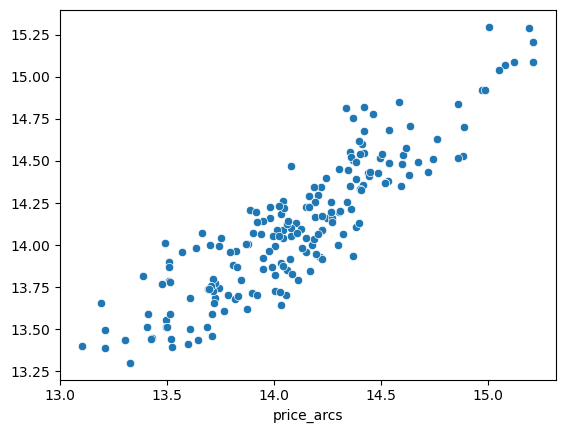

In [91]:
## q2.6 ##

d = 1
expander = PolynomialFeatures(degree = d, include_bias = False)
Z = expander.fit_transform(X_test_n)
names = expander.get_feature_names_out()
X_test_d = pd.DataFrame(data = Z, columns = names)

Z = expander.fit_transform(X_train_n)
names = expander.get_feature_names_out()
X_train_d = pd.DataFrame(data = Z, columns = names)

X_train_d.reset_index(drop = True, inplace = True)
X_train_c.reset_index(drop = True, inplace = True)
X_train_all = pd.concat([X_train_d, X_train_c], axis = 1)
X_train_all.columns = X_train_all.columns.astype(str)

X_test_d.reset_index(drop = True, inplace = True)
X_test_c.reset_index(drop = True, inplace = True)
X_test_all = pd.concat([X_test_d, X_test_c], axis = 1)
X_test_all.columns = X_test_all.columns.astype(str)

regress_all = linear_model.LinearRegression().fit(X_train_all, Y_train)

Y_hat_all = regress_all.predict(X_test_all)
residuals = Y_test - Y_hat_all


sns.scatterplot(x = Y_test, y = Y_hat_all)

<Axes: xlabel='price_arcs', ylabel='Density'>

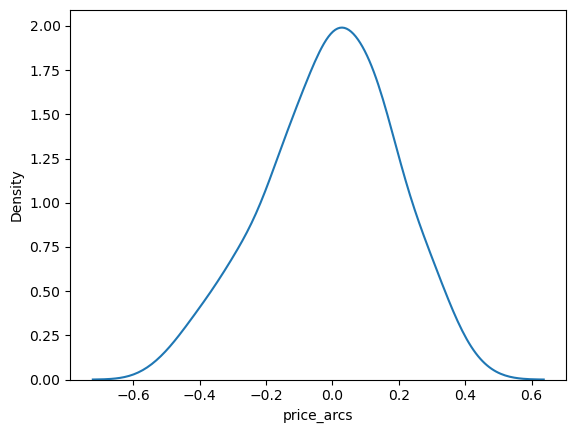

In [92]:
sns.kdeplot(residuals)

the scatterplot demonstrates a strong, positive correlation b/w vars, indicating that the test and true data align pretty well, and the kdeplot is a smooth bell curve, almost perfectly centered around 0, indicating a pretty strong model